In [ ]:
pip install wandb

In [ ]:
pip install emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49719 sha256=6de0d724c32c7a1d29beb1b978f1f11286c8a054d43ef832aa14938e4137a955
  Stored in directory: /root/.cache/pip/wheels/b7/23/31/f9b93f25b95da9b91729c4cd5f35a2b692ab06f688f6759630
Successfully built emoji


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true" # Disable wandb
import wandb

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
import re
import emoji

In [ ]:
# Load the dataset
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [ ]:
def clean_tweet(text):
    text= str(text)                                              # Convert to string if not already
    text = text.lower()                                          # Lowercase
    text = emoji.demojize(text, delimiters=(" :", ": "))         # Convert emojis to text representation
    text = re.sub(r'http\S+|www\.\S+|https\S+', 'HTTPURL', text) # Replace URLs with HTTPURL token
    text = re.sub(r'@\w+', '@USER', text)                        # Replace user mentions with @USER token
    text = re.sub(r'#', '', text)                                # Remove hashtag symbols (keep content)
    text = re.sub(r'&[a-z]+;', '', text)                         # Clean HTML entities
    text = re.sub(r'[^\w\s@:!?.,]', '', text)                    # Remove most special characters (keep important punctuation)
    text = re.sub(r'\s+', ' ', text).strip()                     # Clean excess whitespace
    return text

In [ ]:
# Prepare text and labels
train_texts = train_df["text"].apply(clean_tweet).tolist()
test_texts = test_df["text"].apply(clean_tweet).tolist()
train_labels = train_df["target"].tolist()

# Train-validation split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

In [ ]:
# Load tokenizer and model
model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

def tokenize_data(texts, max_length=128):
    return tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors=None
    )
# Tokenize datasets
train_encodings = tokenize_data(train_texts)
val_encodings = tokenize_data(val_texts)
test_encodings = tokenize_data(test_texts)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [ ]:
# Create Hugging Face Datasets
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': val_labels
})


In [ ]:
# METRICS FUNCTION
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    return {
        'accuracy': accuracy,
        'f1': f1,
    }
# PLOTTING FUNCTIONS
def extract_training_metrics(trainer):
    """Extract training metrics from trainer's log history"""
    logs = trainer.state.log_history

    train_metrics = defaultdict(list)
    eval_metrics = defaultdict(list)
    epochs = []

    current_epoch = 0
    for log in logs:
        if 'loss' in log and 'eval_loss' not in log:   # Training log
            train_metrics['loss'].append(log['loss'])
            train_metrics['epoch'].append(log['epoch'])
        elif 'eval_loss' in log:  # Evaluation log
            eval_metrics['loss'].append(log['eval_loss'])
            eval_metrics['accuracy'].append(log['eval_accuracy'])
            eval_metrics['f1'].append(log['eval_f1'])
            eval_metrics['epoch'].append(log['epoch'])
            epochs.append(log['epoch'])

    return train_metrics, eval_metrics, epochs

def plot_training_history(trainer):
    train_metrics, eval_metrics, epochs = extract_training_metrics(trainer)

    plt.style.use('default')
    sns.set_palette("husl")

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Create subplots
    fig.suptitle('BERTweet Training Progress', fontsize=16, fontweight='bold')

    # Plot 1: Training vs Validation Loss
    ax1 = axes[0]
    if train_metrics['loss'] and eval_metrics['loss']:
        ax1.plot(train_metrics['epoch'], train_metrics['loss'], 'b-', label='Training Loss', linewidth=2, marker='o')
        ax1.plot(eval_metrics['epoch'], eval_metrics['loss'], 'r-', label='Validation Loss', linewidth=2, marker='s')
        ax1.set_title('Training vs Validation Loss', fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        # Set x-axis to increment by 1
        max_epoch = max(max(train_metrics['epoch']), max(eval_metrics['epoch']))
        ax1.set_xticks(range(1, int(max_epoch) + 1))
        ax1.set_xlim(0.5, max_epoch + 0.5)

    # Plot 2: Accuracy vs F1 Score
    ax2 = axes[1]
    if eval_metrics['accuracy'] and eval_metrics['f1']:
        ax2.plot(eval_metrics['epoch'], eval_metrics['accuracy'], 'g-', label='Accuracy',
                linewidth=2, marker='o')
        ax2.plot(eval_metrics['epoch'], eval_metrics['f1'], 'm-', label='F1 Score',
                linewidth=2, marker='s')
        ax2.set_title('Accuracy vs F1 Score', fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Score')
        ax2.set_ylim(0, 1)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        # Set x-axis to increment by 1
        max_epoch = max(eval_metrics['epoch'])
        ax2.set_xticks(range(1, int(max_epoch) + 1))
        ax2.set_xlim(0.5, max_epoch + 0.5)

    plt.tight_layout()
    plt.show()

In [ ]:
# Define Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate= 1.68e-05,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay= 0.01,
    logging_dir='./logs',
    logging_steps=50,
    warmup_steps= 500,                  # Gradually increase learning rate to prevent early training instability and gradient explosions
    load_best_model_at_end=True,        # Loads checkpoint with best performance on validation set
    metric_for_best_model="accuracy",   # Choose metric for load best model
    greater_is_better=True,             # False for loss, True for accuracy (higher=better)
    save_total_limit=2,                 # Keeps 2 most recent model checkpoints for recovery
    gradient_accumulation_steps=2,      # Helps stabilize training
    max_grad_norm= 1.0,                 # Gradient clipping to prevent exploding gradients
    dataloader_pin_memory=False,        # Uses less memory
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


/tmp/ipython-input-3468540820.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.592800,0.412584,0.841103,0.805153
2,0.397800,0.376943,0.845699,0.817405
3,0.375600,0.388803,0.833224,0.807867


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


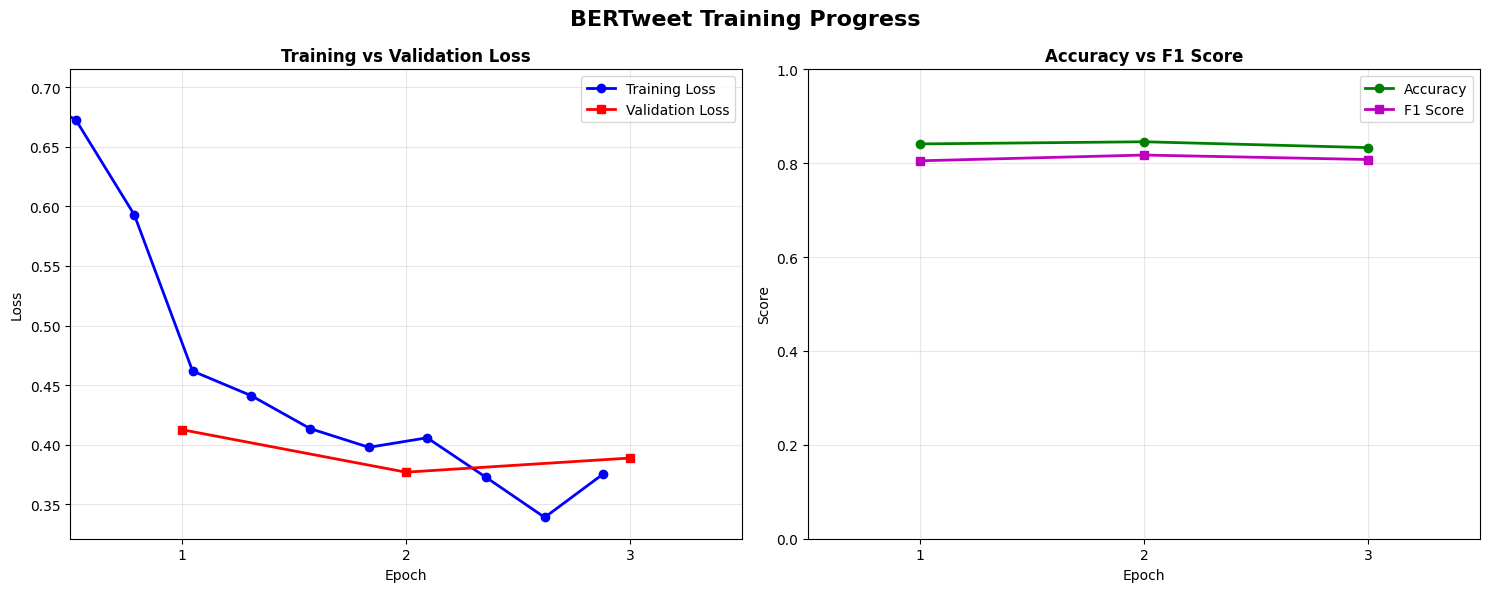

In [ ]:
# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Generate plots
plot_training_history(trainer)

In [ ]:
# Evaluate the model
preds = trainer.predict(val_dataset)
pred_labels = np.argmax(preds.predictions, axis=1)

val_accuracy = accuracy_score(val_labels, pred_labels)
val_f1 = f1_score(val_labels, pred_labels)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")
print("Classification Report:\n", classification_report(val_labels, pred_labels))

# Predict on test set
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask']
})
test_preds = trainer.predict(test_dataset)
test_pred_labels = np.argmax(test_preds.predictions, axis=1)

test_df['prediction'] = test_pred_labels
test_df.to_csv('test_predictions.csv', index=False)
print("Test predictions saved to 'test_predictions.csv'")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Validation Accuracy: 0.8457
Validation F1 Score: 0.8174
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87       869
           1       0.83      0.80      0.82       654

    accuracy                           0.85      1523
   macro avg       0.84      0.84      0.84      1523
weighted avg       0.85      0.85      0.85      1523



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Test predictions saved to 'test_predictions.csv'


In [ ]:
# Print sample predictions
print("\nSample Predictions:")
for i in range(min(8, len(test_texts))):
    print(f"Text {i+1}: {test_texts[i][:300]}...")
    print(f"Prediction {i+1}: {'Disaster' if test_pred_labels[i] == 1 else 'Not Disaster'}")


Sample Predictions:
Text 1: just happened a terrible car crash...
Prediction 1: Disaster
Text 2: heard about earthquake is different cities, stay safe everyone....
Prediction 2: Disaster
Text 3: there is a forest fire at spot pond, geese are fleeing across the street, i cannot save them all...
Prediction 3: Disaster
Text 4: apocalypse lighting. spokane wildfires...
Prediction 4: Disaster
Text 5: typhoon soudelor kills 28 in china and taiwan...
Prediction 5: Disaster
Text 6: were shaking...its an earthquake...
Prediction 6: Disaster
Text 7: theyd probably still show more life than arsenal did yesterday, eh? eh?...
Prediction 7: Not Disaster
Text 8: hey! how are you?...
Prediction 8: Not Disaster
